In [4]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({"figure.figsize": (10, 8), "font.size": 20})

# Dihedral potential with LAMMPS

The aim is to compare the various shapes available in LAMMPS in order to describe the dihedral potential energy and the relation between the corresponding force constants. 

## 1) LAMMPS Dihedral potentials

http://lammps.sandia.gov/doc/dihedral_coeff.html

The available potential energy shapes are : 

* the quadratic dihedral : http://lammps.sandia.gov/doc/dihedral_quadratic.html
\begin{equation}
    V_{quad}(\phi) = \frac{k_{quad}}{2} \left( \phi - \phi_o\right)^2
\end{equation}

* the harmonic dihedral : http://lammps.sandia.gov/doc/dihedral_harmonic.html
\begin{equation}
    V_{harm}(\phi) = k_{harm} \left[ 1 + d \cos\left(n \phi \right) \right]
\end{equation}


* for CHARMM dihedral : http://lammps.sandia.gov/doc/dihedral_charmm.html
\begin{equation}
    V_{charmm}(\phi) = k_{charmm} \left[ 1 + \cos\left(n \phi - \gamma \right) \right]
\end{equation}

Following the Nilson *et al.* (Acta Cryst 2003 D59, 274 - 289) scheme, I consider only the following value of the periodicity : $n\in[1, 2, 3, 6]$. Assuming a dihedral angle such as :

              i        l
               \      /
                j -- k

with `nnj` and `nnk` the number of neighbors of j and k, the Nilson sheeme returning the periodicity (here `p`) is the folowing :

```py
if nnj == nnk:
    if nnj == 2:
        p = 1
    elif nnj == 3:
        p = 2
    elif nnj == 4:
        p = 3
else:
    if max(nnj, nnk) == 2:
        p = 1
    else:
        p = 6
```

Using the CHARMM dihedral, you can chose the positions of the minima of the potential energy. Considering the periodicitiy of the potential, define by $n$, if the first minimum is for $\phi=\phi_{min}$, the phase $\gamma$ reads 

\begin{equation}
    \gamma = n \phi_{min} \pm \pi
\end{equation}

## 2) Relation between harmonic and parabolic shapes

Close to the minimum, one can write a relation between the parabolic and the Charmm/harmonic shapes. Obviously, you cannont defined properly the high of the rotation barrier from the force constant of a parabolic potential.

You have to write a taylor expansion of the cosine function:

\begin{equation}
    \cos x = \sum_{n=0}^{+\infty} \frac{(-1)^n}{(2n)!}x^{2n} = 1 - \frac{x^2}{2} + O(x^4)
\end{equation}

Using the CHARMM equation:

\begin{align}
    V_{charmm} & = k_{charmm} \left[ 1 + \cos\left(n \phi - \gamma \right) \right] \\
               & = k_{charmm} \left[ 1 + 1 - \frac{\left(n \phi - \gamma \right)^2}{2} \right] \\
               & = -\frac{n^2 k_{charmm}}{2} \left( \phi - \frac{\gamma}{n} \right)^2 + 2 k_{charmm}  \\
\end{align}


By identification, the relation between the $k_{charmm}$ and $k_{quad}$ force constants reads:

\begin{equation}
    k_{charmm} = \frac{k_{quad}}{n^2}
\end{equation}

The constant is just a shift in the potential energy and is not relevant.

The same result is obtained in the case of a harmonic potential :

\begin{align}
    V_{harm} & = k_{harm} \left[ 1 + d \cos\left(n \phi \right) \right] \\
               & = k_{harm} \left[ 1 + d - d\frac{\left(n \phi \right)^2}{2} \right] \\
               & = -d \frac{n^2 k_{harm}}{2} \phi^2+ (1 + d) k_{harm}  \\
\end{align}

Again, the relation between the $k_{harm}$ and $k_{quad}$ force constants reads:

\begin{equation}
    k_{harm} = \frac{k_{quad}}{n^2}
\end{equation}

**TODO** : signe moins et position du minimum.

## 3) Dihedral potential functions

In [2]:
def quadratic(val, k, xo=0.):
    """ http://lammps.sandia.gov/doc/dihedral_quadratic.html """
    return k / 2 * (val - xo)**2

def charmm(val, k, n=1, phase=0.):
    """ http://lammps.sandia.gov/doc/dihedral_charmm.html """
    return k * (1 + np.cos(n * val - phase))

def harmonic(val, k, n=1, d=1):
    """ 
    http://lammps.sandia.gov/doc/dihedral_harmonic.html 
    
    Here d = +/- 1
    """
    d = np.sign(d)
    return k * (1 + d * np.cos( n * val))


## 4) The different cases

According to the Nilson scheme, in order to determine the periodicity, we consider the cases corresponding to 2, 3 and 4 neighbors with periodicity of 1, 2 or 3 respectively.

### 4.1) 2 neighbors

For example we consider the hydrogen peroxyde. In order to keep it simple we do not consider the double well potential and consider that the energy minmimum is for $\omega$ = 180° and the energy maximum is for $\omega$=0°.

![h2o2](h2o2.png)

According to Nilson scheme, the periodicity is 1.

In order to get that shape, you have to consider the following parameters for CHARMM potential :

    dihedral_style charmm
    dihedral_coeff  i  k     n   phi_0   w
    dihedral_coeff  1  1.0   1    0.0    1.0

where `w` is a weighting factor and those one for harmonic potential :

    dihedral_style harmonic
    dihedral_coeff i   k_harm   d   n
    dihedral_coeff 1   1.0      1   1
    
**TODO** read the bottom of the [dihedral charmm pages](http://lammps.sandia.gov/doc/dihedral_charmm.html) concerning the weighting factor.

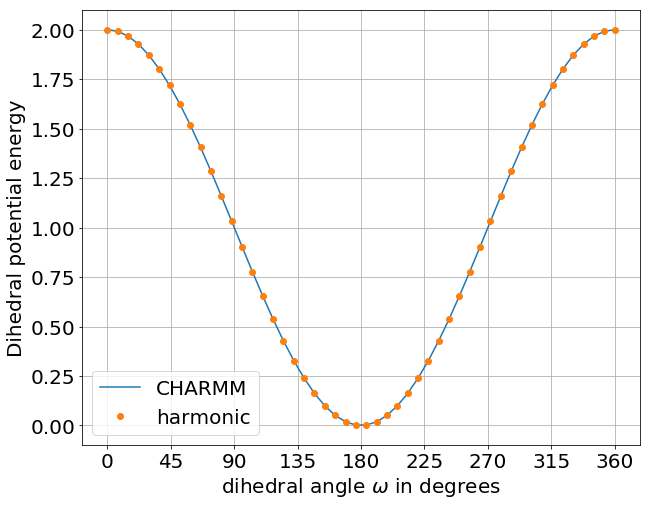

In [5]:
x = np.linspace(0, 360, 50)
plt.plot(x, charmm(np.radians(x), k=1, n=1, phase=0), label="CHARMM")
plt.plot(x, harmonic(np.radians(x), k=1, n=1, d=1), marker="o", label="harmonic", linestyle="")
plt.xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
plt.legend()
plt.xlabel("dihedral angle $\omega$ in degrees")
plt.ylabel("Dihedral potential energy")
plt.grid();

If the minimum is in 0° instead of 180, you have to change the phase in the CHARMM potential and the sign of d in the harmonic potential: 

The CHARMM potential :

    dihedral_style charmm
    dihedral_coeff  i  k     n   phi_0    w
    dihedral_coeff  1  1.0   1   180.0    1.0

the harmonic potential :

    dihedral_style harmonic
    dihedral_coeff i   k_harm    d   n
    dihedral_coeff 1   1.0      -1   1

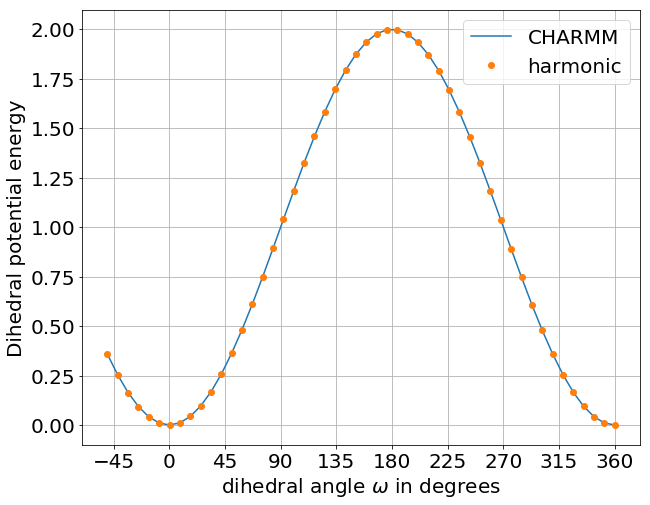

In [6]:
x = np.linspace(-50, 360, 50)
plt.plot(x, charmm(np.radians(x), k=1, n=1, phase=np.pi), label="CHARMM")
plt.plot(x, harmonic(np.radians(x), k=1, n=1, d=-1), marker="o", label="harmonic", linestyle="")
plt.xticks([-45, 0, 45, 90, 135, 180, 225, 270, 315, 360])
plt.xlabel("dihedral angle $\omega$ in degrees")
plt.ylabel("Dihedral potential energy")
plt.legend()
plt.grid();

**remarks :** 

* In the case of the harmonic potential, you cannot choose the position of the minimum. You only have got two possibilities, namely 0° or 180° depending on the sign of $d$ (-1 or +1 respectively).
* In the case of the CHARMM potential, you can choose the position of the minimum with the phase parameter.

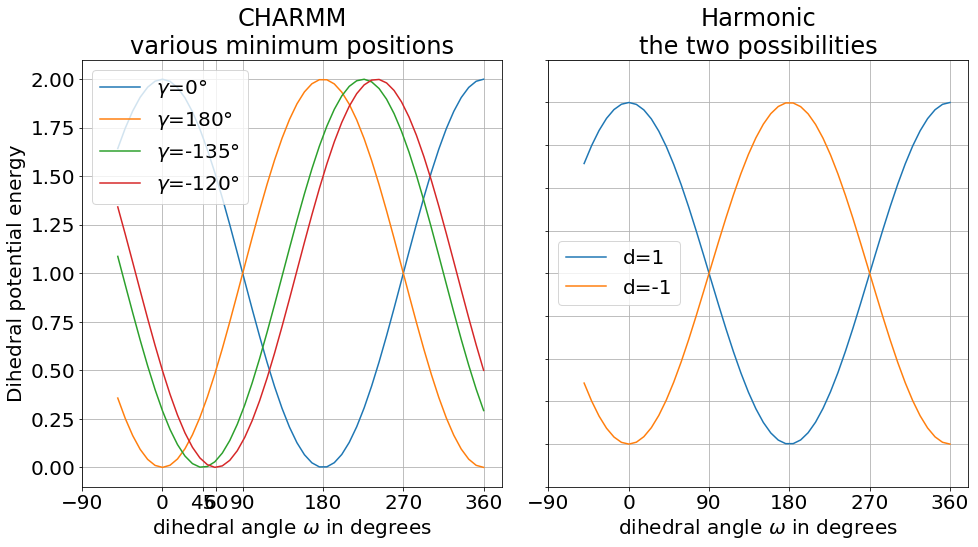

In [7]:
x = np.linspace(-50, 360, 50)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(x, charmm(np.radians(x), k=1, n=1, phase=0), label="$\gamma$=0°")
plt.plot(x, charmm(np.radians(x), k=1, n=1, phase=np.pi), label="$\gamma$=180°")
plt.plot(x, charmm(np.radians(x), k=1, n=1, phase=-3 * np.pi/4), label="$\gamma$=-135°")
plt.plot(x, charmm(np.radians(x), k=1, n=1, phase=4 * np.pi/3), label="$\gamma$=-120°")
plt.xticks(list(range(-90, 450, 90)) + [45, 60])
plt.xlabel("dihedral angle $\omega$ in degrees")
plt.ylabel("Dihedral potential energy")
plt.legend()
plt.grid()
plt.title("CHARMM\nvarious minimum positions")

plt.subplot(1, 2, 2)
plt.plot(x, harmonic(np.radians(x), k=1, n=1, d=1), label="d=1")
plt.plot(x, harmonic(np.radians(x), k=1, n=1, d=-1), label="d=-1")
plt.xticks(range(-90, 450, 90))
plt.xlabel("dihedral angle $\omega$ in degrees")
plt.yticks(plt.yticks()[0], [])
plt.legend()
plt.title("Harmonic\nthe two possibilities")
plt.grid()
plt.tight_layout();

### 4.2) 3 neighbors

This is the case of ethene with the following geometries :

![ethene](3voisins.png)

According to Nilson scheme the periodicity is 2.  Assuming that atom j and k present a sp2 hybridation, the potential energy curves along the dihedral angle must correspond to :

* A minimum for $\omega$ = 0°, 180°
* A maximum for $\omega$ = 90°, 270°

In order to get that shape, you have to consider the following parameters for CHARMM potential :
    
    dihedral_style charmm
    dihedral_coeff  i  k     n   phi_0    w
    dihedral_coeff  1  1.0   2   180.0    1.0

and those one for harmonic potential :

    dihedral_style harmonic
    dihedral_coeff i k_harm   d   n
    dihedral_coeff 1 1.0     -1   2
    

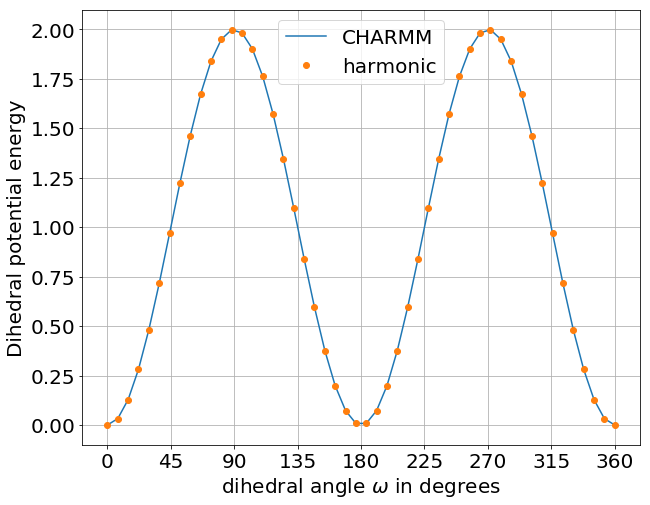

In [8]:
x = np.linspace(0, 360, 50)
plt.plot(x, charmm(np.radians(x), k=1, n=2, phase=np.pi), label="CHARMM")
plt.plot(x, harmonic(np.radians(x), k=1, n=2, d=-1), marker="o", label="harmonic", linestyle="")
plt.xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
plt.legend()
plt.xlabel("dihedral angle $\omega$ in degrees")
plt.ylabel("Dihedral potential energy")
plt.grid();

Again, if the minimum is oposite (a minimum for 90°), you have to change the phase and the sign of d. The following parameters have to be used for the CHARMM potential :
    
    dihedral_style charmm
    dihedral_coeff  i  k     n   phi_0    w
    dihedral_coeff  1  1.0   2   0.0      1.0
    
and those one for harmonic potential :

    dihedral_style harmonic
    dihedral_coeff i   k_harm   d   n
    dihedral_coeff 1   1.0      1   2

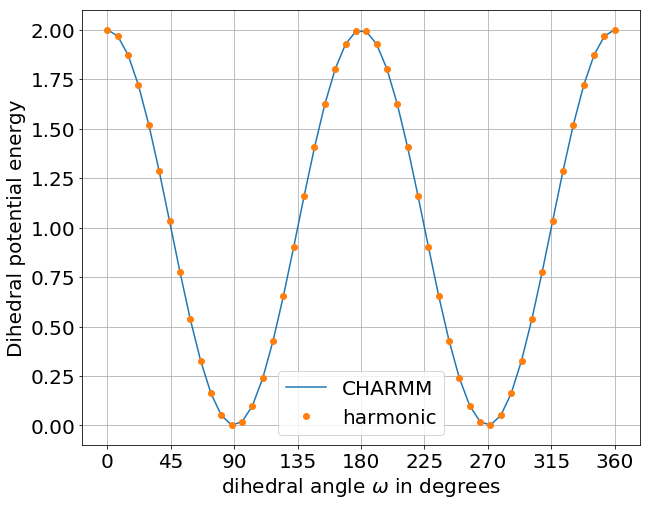

In [9]:
x = np.linspace(0, 360, 50)
plt.plot(x, charmm(np.radians(x), k=1, n=2, phase=0), label="CHARMM")
plt.plot(x, harmonic(np.radians(x), k=1, n=2, d=1), marker="o", label="harmonic", linestyle="")
plt.xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
plt.legend()
plt.xlabel("dihedral angle $\omega$ in degrees")
plt.ylabel("Dihedral potential energy")
plt.grid();

### 4.3) 4 neighbors

This is the cas of ethane withe the following geometries :

![ethane](4voisins.png)

According to Nilson scheme the periodicity is 3.  The potential energy curves along the dihedral angle must correspond to 

* A minimum for $\omega$ = 60°, 180°, 300° ($\pi/3$, $3\pi/3$, $5\pi/3$)
* A maximum for $\omega$ = 0°, 120°, 240° ($0\pi/3$, $2\pi/3$, $4\pi/3$)

In order to get that shape, you have to consider the following parameters for CHARMM potential :
    
    dihedral_style charmm
    dihedral_coeff  i  k    n   phi_0  1.0
    dihedral_coeff  1 0.2   3   0.0    1.0
    
and those one for harmonic potential :

    dihedral_style harmonic
    dihedral_coeff i k_harm d  n
    dihedral_coeff 1 1      1  3    

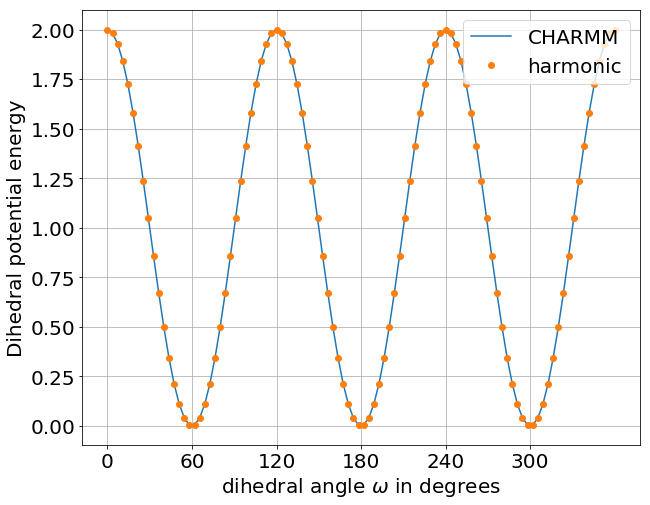

In [10]:
x = np.linspace(0, 360, 100)
plt.plot(x, charmm(np.radians(x), k=1, n=3, phase=0), label="CHARMM")
plt.plot(x, harmonic(np.radians(x), k=1, n=3, d=1), marker="o", label="harmonic", linestyle="")
plt.xticks([0, 60, 120, 180, 240, 300])
plt.legend()
plt.xlabel("dihedral angle $\omega$ in degrees")
plt.ylabel("Dihedral potential energy")
plt.grid();

## 5) Examples

Hereafter, there is some results from mammoth and from PES computed as scan over dihedral angles.

### 5.1) Ethane

The expected energy difference between eclipsed and the shifted conformation is 2.8 kcal.mol-1.

#### Orca results

Mammoth results for ethane with quadratic potential 

    #  atoms        value    k_quad
     H  C  C  H
    (1, 0, 4, 5)     60.0     91.2
    (2, 0, 4, 5)    -60.0     87.2
    (3, 0, 4, 5)    180.0     61.7
    (1, 0, 4, 6)    180.0    178.0
    (2, 0, 4, 6)     60.1    163.4
    (3, 0, 4, 6)    -60.0     92.1
    (1, 0, 4, 7)    -60.1    163.3
    (2, 0, 4, 7)    180.0    150.9
    (3, 0, 4, 7)     60.0     88.0
    
Mammoth results for ethane with harmonic potential 

    #  atoms        value  k_charmm   period
    (1, 0, 4, 5)     60.0     10.1    3
    (2, 0, 4, 5)    -60.0      9.7    3
    (3, 0, 4, 5)    180.0      6.9    3
    (1, 0, 4, 6)    180.0     19.8    3
    (2, 0, 4, 6)     60.1     18.2    3
    (3, 0, 4, 6)    -60.0     10.2    3
    (1, 0, 4, 7)    -60.1     18.1    3
    (2, 0, 4, 7)    180.0     16.8    3
    (3, 0, 4, 7)     60.0      9.8    3

#### Gaussian results with analytic derivatives



(-0.2, 1.5)

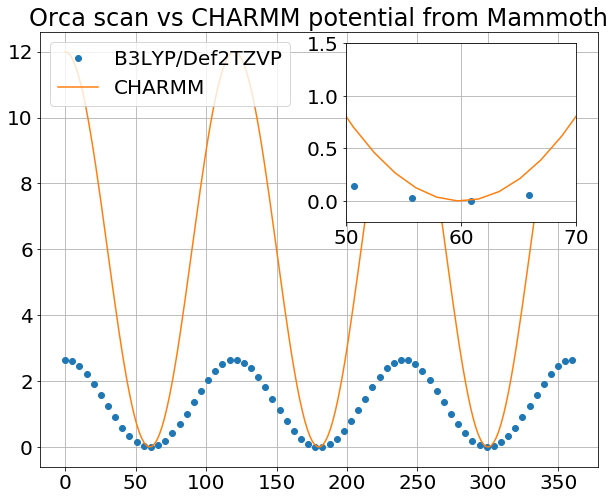

In [84]:
scan = np.loadtxt("../test_gv/ethane/orca/scan_opt.dat").transpose()
plt.plot(scan[0,:], (scan[1, :] - scan[1, :].min()) * 627.509, label="B3LYP/Def2TZVP", marker="o", linestyle="")

x = np.linspace(0, 360, 200)
plt.plot(x, charmm(np.radians(x), k=20 - 14, n=3, phase=0), label="CHARMM")

plt.grid()
plt.legend(loc="upper left")
plt.title("Orca scan vs CHARMM potential from Mammoth")

ax = plt.axes([.55, .55, .32, .31])
ax.plot(scan[0,:], (scan[1, :] - scan[1, :].min()) * 627.509, label="B3LYP/Def2TZVP", marker="o", linestyle="")
ax.plot(x, charmm(np.radians(x), k=20 - 14, n=3, phase=0), label="CHARMM")
ax.grid()
ax.set_xlim((50, 70))
ax.set_ylim((-.2, 1.5))

(-0.2, 1.5)

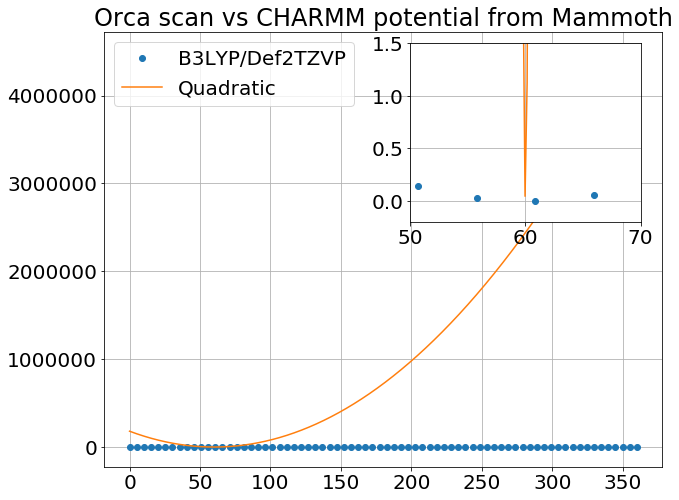

In [52]:
scan = np.loadtxt("../test_gv/ethane/orca/scan_opt.dat").transpose()
plt.plot(scan[0,:], (scan[1, :] - scan[1, :].min()) * 627.509, label="B3LYP/Def2TZVP", marker="o", linestyle="")

x = np.linspace(0, 360, 2000)
plt.plot(x, quadratic(x, k=100, xo=60), label="Quadratic")

plt.grid()
plt.legend(loc="upper left")
plt.title("Orca scan vs CHARMM potential from Mammoth")

ax = plt.axes([.55, .55, .32, .31])
ax.plot(scan[0,:], (scan[1, :] - scan[1, :].min()) * 627.509, label="B3LYP/Def2TZVP", marker="o", linestyle="")
ax.plot(x, quadratic(x, k=100, xo=60), label="Quadratic")
ax.grid()
ax.set_xlim((50, 70))
ax.set_ylim((-.2, 1.5))

### 5.1) Nitromethane

Mammoth results on nitromethane with quadratic dihedrals

    # atoms         phi    k_harm
     H  C  N  O
    (3, 0, 1, 5)   -29.5   362.2
    (4, 0, 1, 5)   152.1   357.4
    (2, 0, 1, 5)    89.2   365.0
    (3, 0, 1, 6)   152.1   362.3
    (4, 0, 1, 6)    29.5   357.5
    (2, 0, 1, 6)   -89.2   365.1
    
Mammoth results on nitromethane with charmm dihedrals

    # atoms          phi    k_charmm  period
     H  C  N  O
    (3, 0, 1, 5)    -29.5     10.1    6
    (4, 0, 1, 5)    152.1      9.9    6
    (2, 0, 1, 5)     89.2     10.1    6
    (3, 0, 1, 6)    152.1     10.1    6
    (4, 0, 1, 6)     29.5      9.9    6
    (2, 0, 1, 6)    -89.2     10.1    6

Text(0.5,1,'Rigid scan on nitromethane')

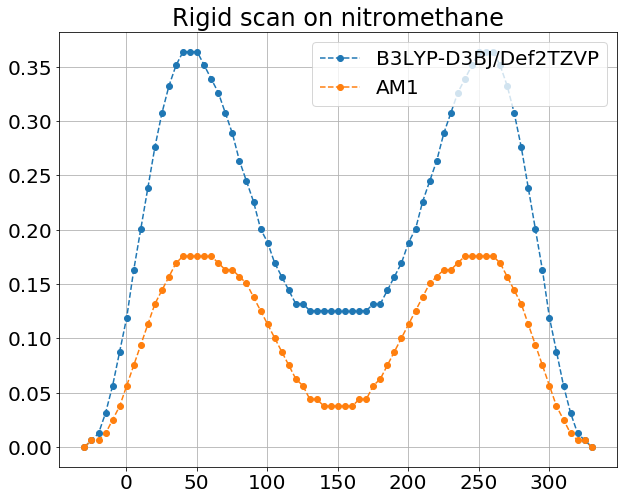

In [12]:
scan = np.loadtxt("../test_gv/nitromethane/scan.dat", usecols=(1, 2)).transpose()
scan_AM1 = np.loadtxt("../test_gv/nitromethane/scan_AM1.dat", usecols=(1, 2)).transpose()
plt.plot(scan[0,:], (scan[1, :] - scan[1, :].min()) * 627.509, label="B3LYP-D3BJ/Def2TZVP", marker="o", linestyle="--")
plt.plot(scan_AM1[0,:], (scan_AM1[1, :] - scan_AM1[1, :].min()) * 627.509, label="AM1", marker="o", linestyle="--")
plt.grid()
plt.legend()
plt.title("Rigid scan on nitromethane")

In [13]:
x = np.linspace(-40, 180, 500)
plt.plot(x, charmm(np.radians(x), k=10.1, n=6, phase=n * np.radians(29.5) + np.pi), label="CHARMM")
plt.plot(x, quadratic(x, 362.2, -29.5), marker="o", label="quadratic")
plt.grid()
plt.vlines(-29.5, -1, 25)
plt.xlim((-90, 90))
plt.ylim((-1, 25))
plt.legend();

NameError: name 'n' is not defined

In [ ]:
ls test_gv/ethane

In [ ]:
scan = np.loadtxt("test_gv/nitromethane/scan.dat", usecols=(1, 2)).transpose()
scan_AM1 = np.loadtxt("test_gv/nitromethane/scan_AM1.dat", usecols=(1, 2)).transpose()
plt.plot(scan[0,:], (scan[1, :] - scan[1, :].min()) * 627.509, label="B3LYP-D3BJ/Def2TZVP", marker="o", linestyle="--")
plt.plot(scan_AM1[0,:], (scan_AM1[1, :] - scan_AM1[1, :].min()) * 627.509, label="AM1", marker="o", linestyle="--")
plt.grid()
plt.legend()
plt.title("Rigid scan on nitromethane")

### 1) About the charmm potential

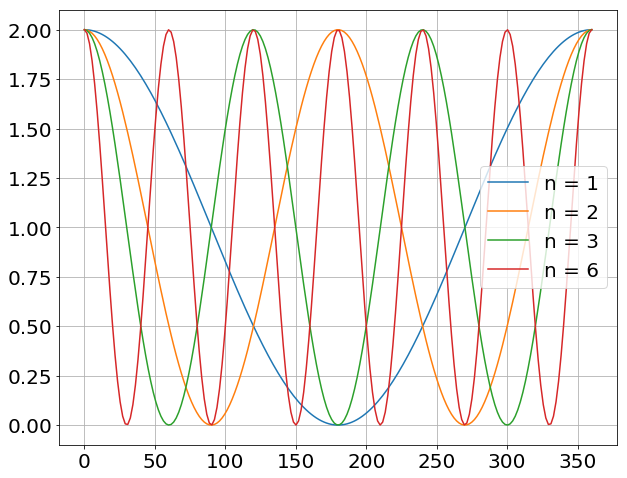

In [14]:
x = np.linspace(0, 360, 200)
for n in [1, 2, 3, 6]:
    plt.plot(x, charmm(np.radians(x), k=1, n=n, phase=0), label="n = %d" % n)
plt.grid()
plt.legend();

In order to have a minimum at 180° one needs that even periodicity have a phase of $\pi$.

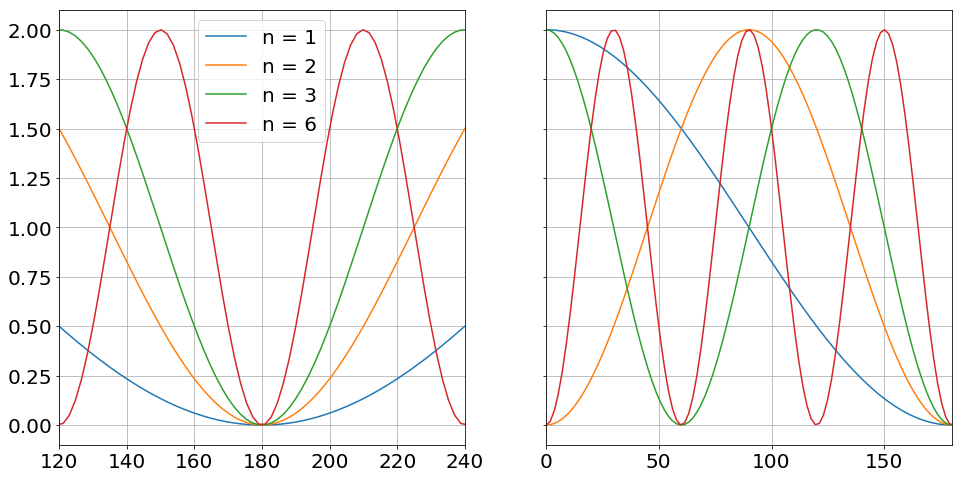

In [15]:
x = np.linspace(0, 360, 200)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8), sharey=True)
ax1.plot(x, charmm(np.radians(x), k=1, n=1, phase=0), label="n = 1")
ax1.plot(x, charmm(np.radians(x), k=1, n=2, phase=np.pi), label="n = 2")
ax1.plot(x, charmm(np.radians(x), k=1, n=3, phase=0), label="n = 3")
ax1.plot(x, charmm(np.radians(x), k=1, n=6, phase=np.pi), label="n = 6")
ax1.grid()
ax1.set_xlim((120, 240))
ax1.legend();

ax2.plot(x, charmm(np.radians(x), k=1, n=1, phase=0), label="n = 1")
ax2.plot(x, charmm(np.radians(x), k=1, n=2, phase=np.pi), label="n = 2")
ax2.plot(x, charmm(np.radians(x), k=1, n=3, phase=0), label="n = 3")
ax2.plot(x, charmm(np.radians(x), k=1, n=6, phase=np.pi), label="n = 6")
ax2.set_xlim((0, 180))
ax2.grid();

In order to have a minimum at 0° one needs the phase of all periodicity to be equal at $\pi$.

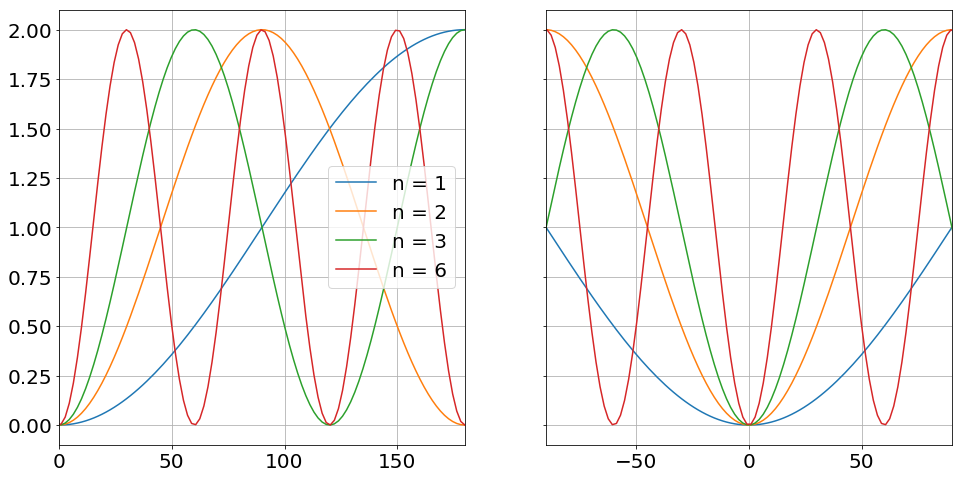

In [16]:
x = np.linspace(-180, 180, 200)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8), sharey=True)
ax1.plot(x, charmm(np.radians(x), k=1, n=1, phase=np.pi), label="n = 1")
ax1.plot(x, charmm(np.radians(x), k=1, n=2, phase=np.pi), label="n = 2")
ax1.plot(x, charmm(np.radians(x), k=1, n=3, phase=np.pi), label="n = 3")
ax1.plot(x, charmm(np.radians(x), k=1, n=6, phase=np.pi), label="n = 6")
ax1.grid()
ax1.set_xlim((0, 180))
ax1.legend();

ax2.plot(x, charmm(np.radians(x), k=1, n=1, phase=np.pi), label="n = 1")
ax2.plot(x, charmm(np.radians(x), k=1, n=2, phase=np.pi), label="n = 2")
ax2.plot(x, charmm(np.radians(x), k=1, n=3, phase=np.pi), label="n = 3")
ax2.plot(x, charmm(np.radians(x), k=1, n=6, phase=np.pi), label="n = 6")
ax2.set_xlim((-90, 90))
ax2.grid();

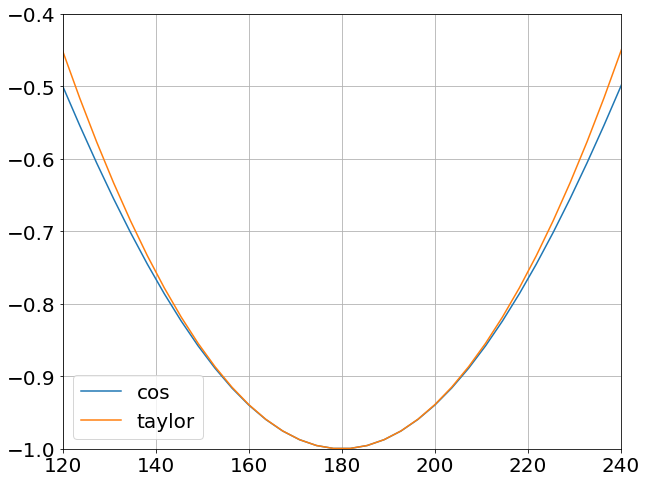

In [59]:
xx = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.degrees(xx), -np.cos(xx - np.pi), label="cos")
plt.plot(np.degrees(xx), -1 + (xx - np.pi)**2 / 2, label="taylor")
plt.grid()
plt.xlim((120, 240))
plt.ylim((-1, -0.4))
plt.legend()

In [82]:
np.degrees(1)

57.29577951308232

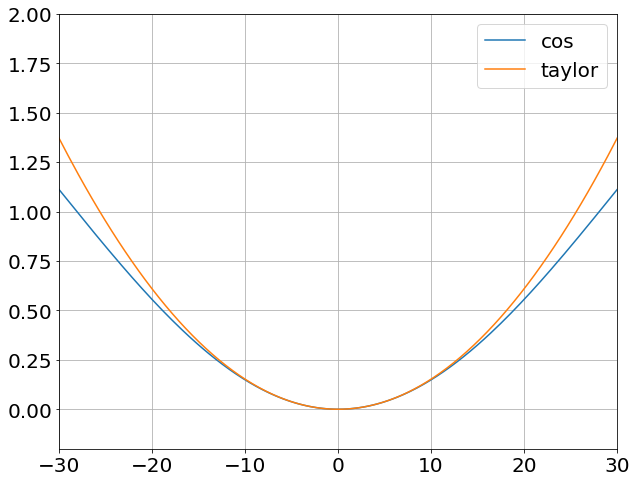

In [81]:
xx = np.linspace(-np.pi, np.pi, 1000)

kq = 10
n = 3
gam = np.pi
xo = 0
kh = kq / n**2

plt.plot(np.degrees(xx), kh * (1 + np.cos(n * xx - gam)), label="cos")
plt.plot(np.degrees(xx), kq * (xx - xo)**2 / 2, label="taylor")
plt.grid()
plt.xlim((-30, 30))
plt.ylim((-0.2, 2))
plt.legend()